In [1]:
from aicspylibczi import CziFile
import czifile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.animation as animation
import seaborn as sns
import IPython
from IPython.display import HTML
import ffmpeg

In [2]:
from scipy.stats import sigmaclip
from multiprocessing import Pool
import os
import cv2
import skimage
import skimage.measure as skm
from skimage.measure import label, regionprops_table # version at least 0.22
from skimage.filters import threshold_otsu # version at least 0.22


import mahotas
import scipy
from scipy.spatial import distance
import skimage.measure as sk

from sklearn.decomposition import PCA

In [3]:
from utils import *

In [4]:
processed_video_files = [
    ("processed", 3),
    ('processed', 6),
    ('processed', 9),
]
mip_video_files = [
    ('mip', 3),
    ('mip', 6),
    ('mip', 9),
]

## Early EDA

In [5]:
def extract_traces(frames, masks, hist=2, load_verifying_videos=True):
    bboxes, num_cells, areas = bounding_boxes(masks[0])
    vid_data = []
    videos_for_checking = []
    for i in range(num_cells):
        #print("Extracting cell ", i)
        data = track_cells(i, frames, masks, padding=0, history_length=hist, verbose=False)
        vid_data.append(data)
        if(load_verifying_videos):
            videos_for_checking.append(np.array(visualize_cell_tracker(frames, data)))

    return(vid_data, videos_for_checking)

In [6]:
class VideoDataMIP:
    def __init__(self, files):
        self.data = {}
        for category, num in files:
            print(f"Loading in MIP {num}")
            assert category == 'mip', "Can't load non Mip file"
            file = {}
            file['video'] = get_file(category, num)
            
            frames, shp = file['video'].read_image(C=0)
            frames = scale_img(frames.squeeze())
            file['frames'] = frames
            print(f"frames {num}: {frames.shape}")
            file['masks'] = binarize_video(frames)

            self.data[num] = file

    def extract_all_traces(self, file_num, sequence_length=-1, hist_length=2, load_vids=True):
        # hist length is how many frames of history
        frames, masks = self.data[file_num]['frames'], self.data[file_num]['masks']
        N = len(frames)
        s = 0
        if(sequence_length < 0):
            all_traces, all_videos = extract_traces(frames, masks, hist=hist_length, load_verifying_videos=load_vids)
        else:
            all_traces = []
            all_videos = []
            for i in range(N // sequence_length):
                
                # print(f"Extracting traces from {s}:{s+sequence_length}")
                data, videos = extract_traces(frames[s:s+sequence_length], masks[s:s+sequence_length], 
                                              hist=hist_length, load_verifying_videos=load_vids)
                s += sequence_length
                all_traces = all_traces + data
                all_videos = all_videos + videos
            
            if(N % sequence_length > 0):
                data, videos = extract_traces(frames[-1*sequence_length:], masks[-1*sequence_length:], hist=hist_length)
                all_traces = all_traces + data
                all_videos = all_videos + videos

        self.data[file_num]['traces'] = all_traces
        self.data[file_num]['trace_videos'] = all_videos

In [7]:
videos = VideoDataMIP([('mip', 3),('mip', 6),
    ('mip', 9) ])

Loading in MIP 3
Loading dicty_factin_pip3-03_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 90)}]
frames 3: (90, 2048, 474)
Loading in MIP 6
Loading dicty_factin_pip3-06_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 241)}]
frames 6: (241, 2048, 474)
Loading in MIP 9
Loading dicty_factin_pip3-09_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 241)}]
frames 9: (241, 2048, 474)


In [8]:
videos.extract_all_traces(file_num=3, sequence_length= -1, hist_length=2, load_vids=True)

In [9]:
videos.extract_all_traces(file_num=6, sequence_length=-1, hist_length=2, load_vids=True)

In [10]:
videos.extract_all_traces(file_num=9, sequence_length=-1, hist_length=2, load_vids=True)

In [41]:
len(videos.data)

3

In [187]:
mip3 = videos.data[6]
mip3.keys()

dict_keys(['video', 'frames', 'masks', 'traces', 'trace_videos'])

In [156]:
len(mip3['traces'])

11

In [46]:
mip3['traces'][0].keys()

dict_keys(['patches', 'boxes', 'masks'])

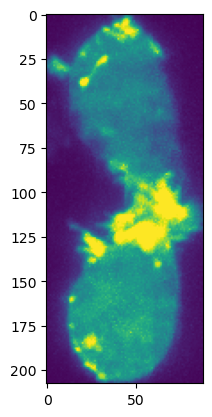

In [47]:
imshow(mip3['traces'][0]['patches'][1])
plt.show()

In [48]:
def animate_frames(frames):
    fig = plt.figure()
    im = plt.imshow(frames[0])
    
    plt.close() # this is required to not display the generated image
    
    def init():
        im.set_data(frames[0])
    
    def animate(i):
        im.set_data(frames[i])
        return im
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frames),
                                   interval=200)
    
    HTML(anim.to_html5_video())
    plt.show()
    return(anim)

In [188]:
anime = animate_frames(mip3['trace_videos'][0])
HTML(anime.to_html5_video())

In [50]:
len(mip3['trace_videos'])

7

In [ ]:
frames = mip3['trace_videos'][1]
frames.shape

In [116]:
mip3['frames'].shape

(241, 2048, 474)

In [159]:
box_video, num, areas = box_tracking_video(mip3['frames'], mip3['masks'], thickness=3)

In [160]:
box_frames = 255 * np.array(box_video)
#frames = frames.astype(np.uint8)

In [161]:
sns.reset_orig()

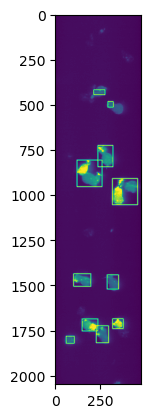

In [162]:
imshow(box_frames[0])
plt.show()

In [45]:
!conda install -c conda-forge ffmpeg -y

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.



In [15]:
anim = animate_frames(box_frames)
HTML(anim.to_html5_video())

NameError: name 'box_frames' is not defined

In [57]:
frames.shape

(90, 2048, 474)

In [59]:
def write_video(frames, output_filename, fps=15):
    """
    Parameters:
        frames (list): List of numpy array frames.
        output_filename (str): Output video filename.
        fps (float): Frames per second of the output video (default is 25).

    Returns:
        None
    """
    # Get frame shape (height, width)
    frame_shape = frames[0].shape[:2]
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change codec as per your requirement ('XVID', 'MJPG', etc.)
    out = cv2.VideoWriter(output_filename, fourcc, fps, frame_shape[::-1])  # Note: frame_shape[::-1] to match (width, height)

    # Write frames to the video
    for frame in frames:
        out.write(frame)

    # Release the VideoWriter object
    out.release()

# Example usage:
# Generate some example frames
output_filename = 'cell_vid2.mp4'
write_video(box_frames.astype(np.uint8), output_filename)

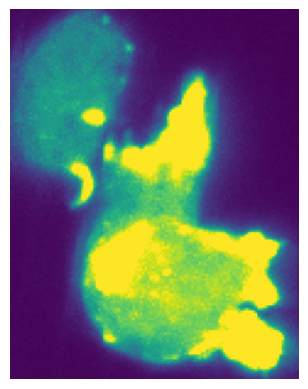

In [58]:
imshow(mip3['traces'][1]['patches'][3])
plt.axis('off')
plt.show()

In [ ]:
anim = animate_frames(frames)
HTML(anim.to_html5_video())

In [61]:
imshow(binary)

c = skm.centroid(binary)
plt.plot(c[1], c[0], 'g+', markersize=8)
plt.show()

NameError: name 'binary' is not defined

In [ ]:
def get_centroids(cell_data):
    boxes, masks = np.array(cell_data['boxes']), cell_data['masks']
    N = len(masks)
    res = []
    centroids = [skm.centroid(binary.astype(np.uint8)) for binary in masks]
    for i in range(N):
        c = centroids[i]
        ymin, xmin = boxes[i][:2]
        res.append([xmin+c[0], ymin+c[1]])
    return(np.array(res) - res[0])

In [ ]:
mip3['trace_videos'][23][0].shape

In [ ]:
anim = animate_frames(mip3['trace_videos'][19])
HTML(anim.to_html5_video())

In [ ]:
mip3['traces'][19]['boxes']

In [ ]:
get_centroids(mip3['traces'][19])

In [ ]:
get_centroids(mip3['traces'][23])

In [ ]:
def plot_trajectory(cell_data):
    loc = get_centroids(cell_data)
    xs, ys = loc[:,0], loc[:,1]
    plt.plot(xs, ys, 'bo')
    plt.plot(xs, ys, 'r--')
    plt.plot(xs[0], ys[0], 'g*', markersize=10, label='Start')
    plt.legend()
    plt.show()

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
frames = mip3['trace_videos'][4]

In [16]:
anim = animate_frames(frames)
HTML(anim.to_html5_video())

NameError: name 'frames' is not defined

In [ ]:
plot_trajectory(mip3['traces'][4])

In [62]:
anim = animate_frames(mip3['trace_videos'][12])
HTML(anim.to_html5_video())

IndexError: list index out of range

## Pixel Intensity Analysis

In [164]:
demo_vid = mip3['traces'][4]['patches']

In [74]:
demo_vid[0].max()

1.0

In [75]:
np.histogram(demo_vid[10], bins=3)

(array([3487, 2404, 1039]),
 array([0.01604278, 0.34402852, 0.67201426, 1.        ]))

In [76]:
# j = 18
# demo_vid = mip3['traces'][j]['patches']

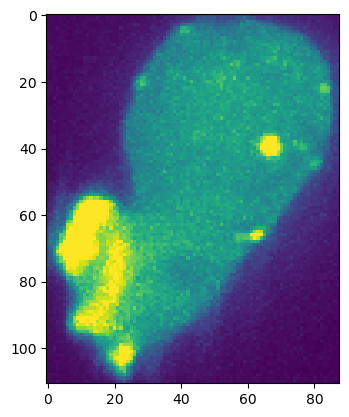

In [168]:
imshow(demo_vid[45])
plt.show()

In [60]:
len(demo_vid)

241

In [169]:
n, bins, fig = plt.hist(demo_vid[45].flatten(), bins=100, density=False)
n

array([ 26., 215., 469., 508., 488., 336., 310., 240., 211., 217., 143.,
       123., 110., 122.,  94.,  88.,  75.,  76.,  93.,  58.,  60.,  50.,
        65.,  49.,  42.,  46.,  41.,  43.,  35.,  28.,  39.,  45.,  28.,
        22.,  34.,  27.,  37.,  38.,  35.,  33.,  59.,  61.,  58.,  88.,
       105., 130., 143., 151., 145., 183., 264., 252., 231., 254., 274.,
       242., 232., 189., 196., 186., 131., 113.,  80.,  84.,  56.,  63.,
        33.,  43.,  49.,  31.,  19.,  21.,  44.,  34.,  14.,  19.,  19.,
        28.,  22.,  14.,  12.,  19.,  21.,  15.,  16.,  23.,  19.,  16.,
        23.,  14.,  12.,  20.,  21.,  14.,  17.,  24.,  15.,  12.,  12.,
       284.])

In [ ]:
# plt.bar(n, bins)

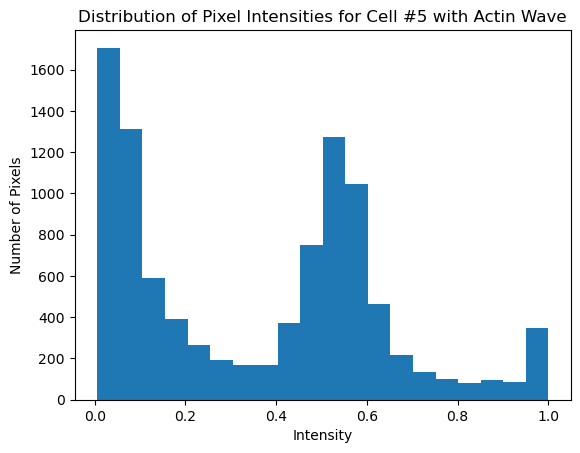

In [176]:
plt.hist(demo_vid[45].flatten(), bins=20, density=False)
plt.title('Distribution of Pixel Intensities for Cell #5 with Actin Wave')
plt.ylabel('Number of Pixels')
plt.xlabel('Intensity')
plt.show()

In [73]:
bins

array([0.01012829, 0.34008553, 0.67004276, 1.        ])

In [74]:
imshow(demo_vid[3])

In [75]:
imshow(np.logical_and(0.338 < demo_vid[3], demo_vid[3] < 0.67))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# Cell Featurization

In [19]:
mip3 = videos.data[3]['traces']
len(mip3)

67

In [11]:
image, binary = mip3[2]['patches'][0], mip3[2]['masks'][0].astype(np.uint8) 
image.shape, binary.shape

((142, 104), (142, 104))

In [11]:
def shape_features(binary, feature_length=20, num_samples=180):
    def radial_distance(binary, theta):
        height, width = binary.shape
        center = [width // 2, height // 2]
        def test_r(r):
            x_test, y_test = center[0] + r*np.cos(theta), center[1] + r*np.sin(theta)
            if(x_test >= width or y_test > height or x_test < 0 or y_test < 0):
                return(False)
            return(binary[int(y_test), int(x_test)])
        # calculate distance to the nearest pixel
        r = max(height, width)
        while(not test_r(r)): # start from edge come inside until hit cell
            r -= 1
        return(r)

    test_angles = np.linspace(0, 2*np.pi, num_samples)
    distances = np.array([radial_distance(binary, angle) for angle in test_angles])
    fft_coefficients = np.fft.rfft(distances)

    features = np.abs(fft_coefficients[:feature_length])
    features = features / np.sum(features)
    return(features, (distances, fft_coefficients))

#### Radial Shape features

In [38]:
f, coeffs = shape_features(binary)

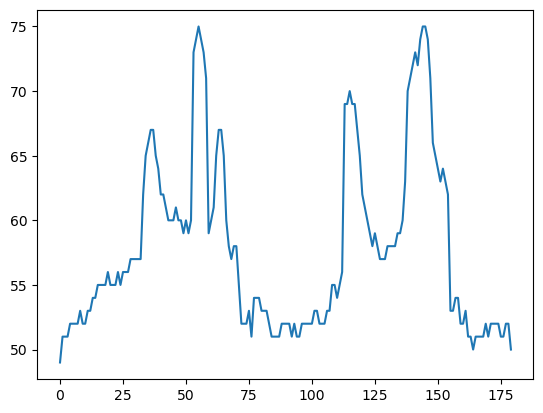

In [163]:
plt.plot(np.fft.irfft(coeffs), label='pred')

In [94]:
def radial_distance(binary, theta):
    height, width = binary.shape
    center = [width // 2, height // 2]
    def test_r(r):
        x_test, y_test = center[0] + r*np.cos(theta), center[1] + r*np.sin(theta)
        if(x_test >= width or y_test > height or x_test < 0 or y_test < 0):
            return(False)
        return(binary[int(y_test), int(x_test)])
    # calculate distance to the nearest pixel
    r = max(height, width)
    while(not test_r(r)): # start from edge come inside until hit cell
        r -= 1
    return(r)
        

CPU times: user 259 µs, sys: 84 µs, total: 343 µs
Wall time: 348 µs


49

In [97]:
def test_r(binary, theta, r, viz=False):
    height, width = binary.shape
    center = [width // 2, height // 2]
    x_test, y_test = center[0] + r*np.cos(theta), center[1] + r*np.sin(theta)
    print(f"Testing {x_test}, {y_test}")
    if(viz):
        plt.imshow(binary)
        plt.plot(x_test, y_test, 'rx', markersize=8)
        plt.plot(center[0], center[1], 'go', markersize=5)
    if(x_test >= width or y_test > height or x_test < 0 or y_test < 0):
        print("Out of bounds")
        return(False)
    return(binary[int(y_test), int(x_test)])

[52, 71]
Testing 80.5, 120.363448015713
final: 120, 80
CPU times: user 18.7 ms, sys: 7.59 ms, total: 26.2 ms
Wall time: 20.8 ms


1

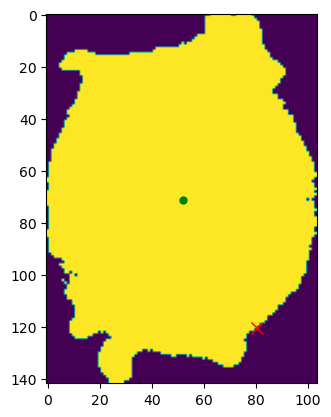

In [100]:
%%time
angle= np.pi/3
r = radial_distance(binary, angle)
test_r(binary, angle, r, True)

In [153]:
%%time
test_angles = np.linspace(0, 2*np.pi, 150)
distances = np.array([radial_distance(binary, angle) for angle in test_angles])

CPU times: user 31.4 ms, sys: 0 ns, total: 31.4 ms
Wall time: 31.6 ms


In [147]:
distances

array([49, 54, 56, 65, 59, 67, 53, 52, 53, 70, 57, 72, 63, 51, 50])

In [152]:
fft_coefficients

(8,)

In [156]:
np.abs(fft_coefficients[:15])

array([8689.        ,   78.89888164,  553.19887243,   51.54753403,
        177.15901665,  121.36703969,  228.78981573,  185.95391389,
        111.20845436,  114.02428067,   49.03708924,   60.45520967,
         87.92142009,   17.47809276,   60.32052281])

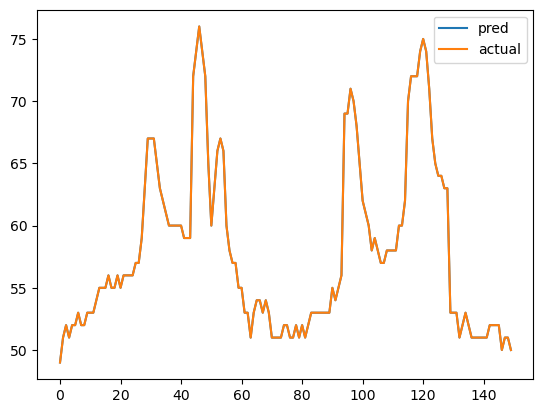

In [154]:
fft_coefficients = np.fft.rfft(distances)
plt.plot(np.fft.irfft(fft_coefficients), label='pred')
plt.plot(distances, label='actual')
plt.legend()
plt.show()

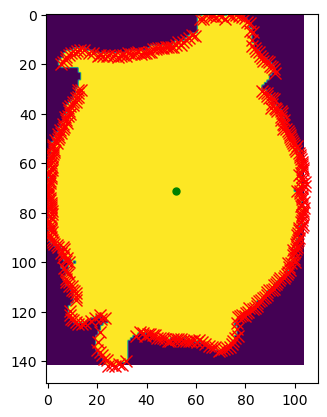

In [106]:
plt.imshow(binary)
height, width = binary.shape
center = [width // 2, height // 2]
plt.plot(center[0], center[1], 'go', markersize=5)
for i in range(360):
    r = distances[i]
    theta = test_angles[i]
    x_test, y_test = center[0] + r*np.cos(theta), center[1] + r*np.sin(theta)
    plt.plot(x_test, y_test, 'rx', markersize=8)



In [9]:
dist = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
dist_output = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

NameError: name 'binary' is not defined

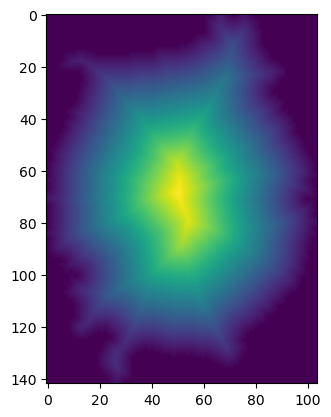

In [41]:
imshow(dist_output)

### Putting it all together

In [12]:
def featurize(cell_data, index):
    image, binary = cell_data['patches'][index], cell_data['masks'][index].astype(np.uint8)
    zernike = mahotas.features.zernike_moments(binary, max(binary.shape)/2, degree=8)
    #zernike = zernike / zernike.sum()
    haralick = mahotas.features.haralick(image.astype(np.uint16)).mean(axis=0)
    #haralick = haralick / haralick.sum()
    shape, info = shape_features(binary, 20)
    #print(f"Zernike: {zernike.shape}, Haralick: {haralick.shape}, Radial Shape: {shape.shape}")
    return(np.concatenate([zernike, haralick, shape]))

In [66]:
trajectory_features = np.array([featurize(mip3[1], index) for index in range(10)])

In [67]:
trajectory_features.shape

(10, 58)

In [69]:
pca = PCA(n_components=3, svd_solver='full')
pca.fit(trajectory_features)

PCA(n_components=3, svd_solver='full')

In [70]:
pca.explained_variance_ratio_

array([0.86144076, 0.11237322, 0.01582193])

In [71]:
pca.components_.shape

(3, 58)

In [72]:
embeddings = pca.fit_transform(trajectory_features)

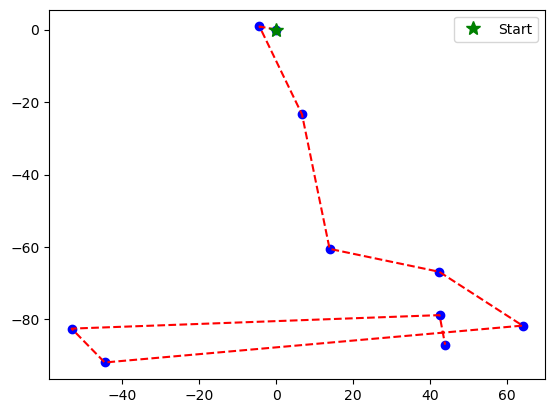

In [73]:
plot_trajectory(mip3[1])

In [74]:
embeddings

array([[-0.98541309, -0.27325282,  0.05565165],
       [-1.05264267, -0.41667195,  0.01039512],
       [-0.71589596, -0.19655802, -0.00191692],
       [-0.00353909,  0.26097913, -0.11785941],
       [-0.10688844,  0.33834534,  0.12814296],
       [-0.05625086,  0.4433365 ,  0.191271  ],
       [ 1.45423494, -0.24478917,  0.02934828],
       [ 1.45832976, -0.29861703,  0.03132811],
       [-0.03551561,  0.15139073, -0.18086823],
       [ 0.04358102,  0.2358373 , -0.14549258]])

In [58]:
c = get_centroids(mip3[1])
c

In [91]:
def compute_trajectory_similarity(t1, t2):
    assert len(t1) == len(t2), "trajectories should be same length"
    def normalized_deltas(t):
        deltas = np.abs(np.array([t[i+1,:2] - t[i,:2] for i in range(len(t)-1)] ))
        return(deltas / np.sum(deltas, axis=0))
    d1 = normalized_deltas(t1)
    d2 = normalized_deltas(t2)
    #print(d1,"\n")
    #print(d2,"\n")
    #print(np.abs(d1-d2), "\n")
    return(np.abs(d1-d2).mean())
    

In [87]:
compute_trajectory_similarity(embeddings, c)

[[0.01542726 0.06290767]
 [0.07727372 0.09654817]
 [0.16346548 0.20068867]
 [0.02371571 0.033935  ]
 [0.01161987 0.04605208]
 [0.3466132  0.30183129]
 [0.00093964 0.02361042]
 [0.3427947  0.19738607]
 [0.01815041 0.03704064]] 

[[0.01523492 0.00762151]
 [0.03851834 0.21131276]
 [0.02499933 0.32318094]
 [0.09926052 0.05505995]
 [0.07546501 0.12940926]
 [0.37833193 0.08859475]
 [0.03000003 0.08139951]
 [0.3331514  0.03240822]
 [0.00503852 0.07101311]] 

[[1.92340378e-04 5.52861618e-02]
 [3.87553788e-02 1.14764590e-01]
 [1.38466150e-01 1.22492265e-01]
 [7.55448014e-02 2.11249510e-02]
 [6.38451310e-02 8.33571801e-02]
 [3.17187345e-02 2.13236535e-01]
 [2.90603883e-02 5.77890982e-02]
 [9.64330064e-03 1.64977848e-01]
 [1.31118849e-02 3.39724613e-02]] 



0.07040773338656366

In [92]:
def compute_trajectory_similarity(t1, t2):
    assert len(t1) == len(t2), "trajectories should be same length"
    def normalized_deltas(t):
        deltas = np.abs(np.array([t[i+1,:2] - t[i,:2] for i in range(len(t)-1)] ))
        return(deltas / np.sum(deltas, axis=0))
    d1 = normalized_deltas(t1)
    d2 = normalized_deltas(t2)
    #print(d1,"\n")
    #print(d2,"\n")
    #print(np.abs(d1-d2), "\n")
    return(np.abs(d1-d2).mean())

pca = PCA(n_components=3, svd_solver='full')
def trajectory_shape_loc_comparison(cell_data):
    trajectory_features = np.array([featurize(cell_data, index) for index in range(len(cell_data['boxes']))])
    loc = get_centroids(cell_data)
    embeddings = pca.fit_transform(trajectory_features)
    diff = compute_trajectory_similarity(loc, embeddings)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
    # Plot on the first subplot (axs[0])
    axs[0].plot(loc[1:,0], loc[1:,1], 'bo')
    axs[0].plot(loc[:,0], loc[:,1], 'r--')
    axs[0].plot(loc[0,0], loc[0,1], 'g*', markersize=10, label='Start')
    axs[0].set_title('Trajectory of Cell Centroid')
    
    # Plot on the second subplot (axs[1])
    axs[1].plot(embeddings[1:,0], embeddings[1:,1], 'ro')
    axs[1].plot(embeddings[:,0], embeddings[:,1], 'b--')
    axs[1].plot(embeddings[0,0], embeddings[0,1], 'g*')
    axs[1].set_title("Trajectory of Principal Components of Extracted Features")
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    return(diff)

In [ ]:
compute_trajectory_similarity

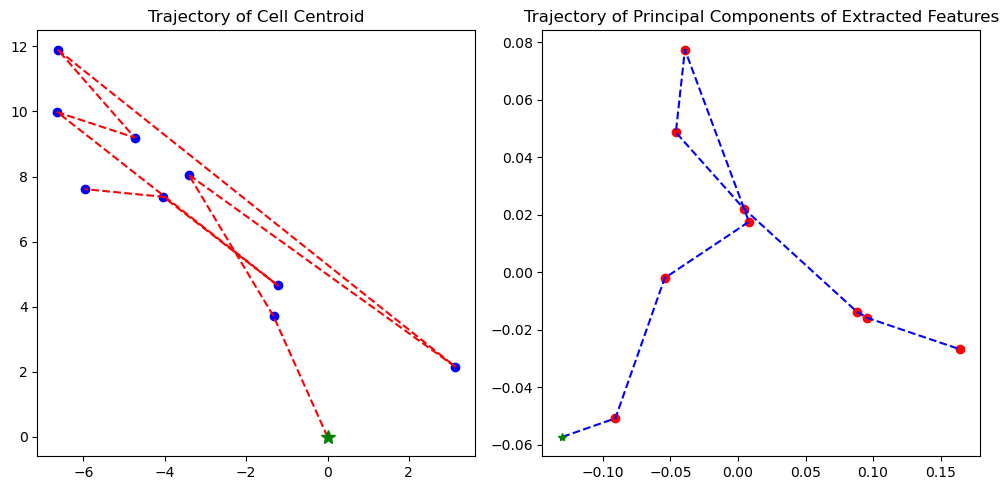

In [93]:
diff = trajectory_shape_loc_comparison(mip3[2])

In [96]:
diff, diff2

(0.06328102897816988, 0.07040773338656366)

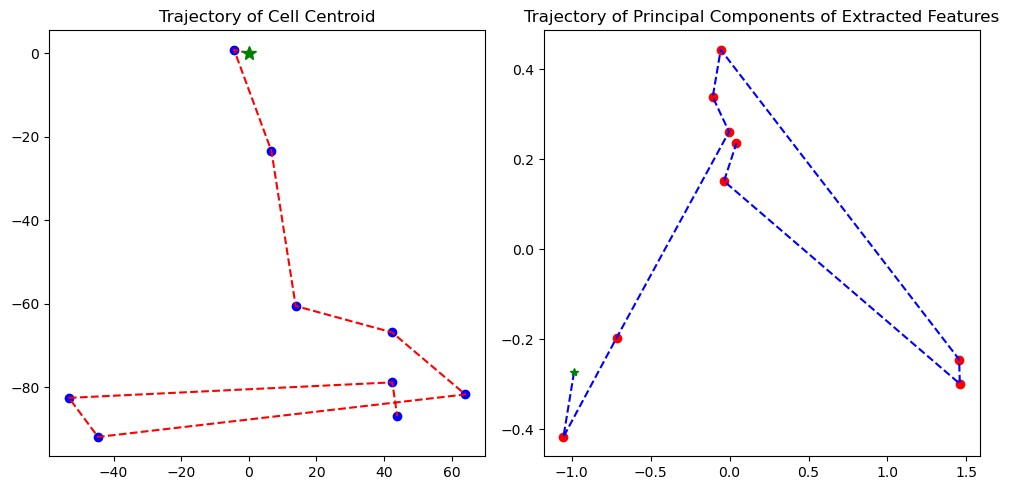

In [95]:
diff2 = trajectory_shape_loc_comparison(mip3[1])

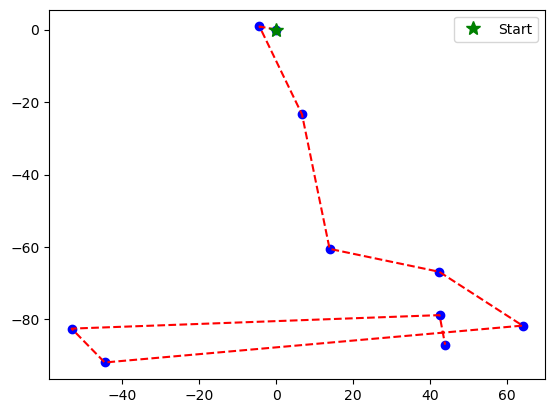

In [38]:
plot_trajectory(mip3[1])

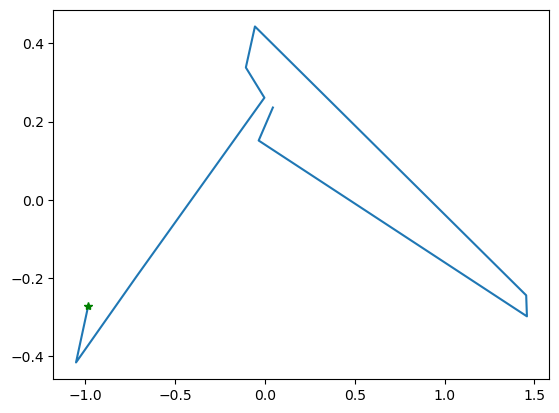

In [35]:
plt.plot(embeddings[:,0], embeddings[:,1])
plt.plot(embeddings[0,0], embeddings[0,1], 'g*')

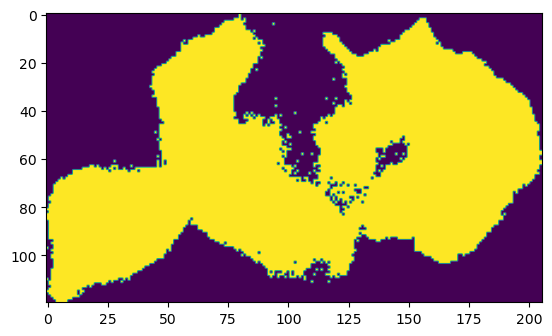

In [92]:
demo = mip6[20]
mask = demo['masks'][1].astype(np.uint8)
m1 = mahotas.features.zernike_moments(mask, max(mask.shape)/2, degree=8)
imshow(mask)

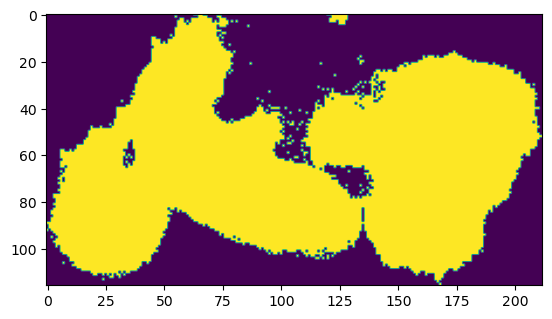

In [93]:
demo = mip6[20]
mask2 = demo['masks'][4].astype(np.uint8)
m2 = mahotas.features.zernike_moments(mask2, max(mask2.shape)/2, degree=8)
imshow(mask2)

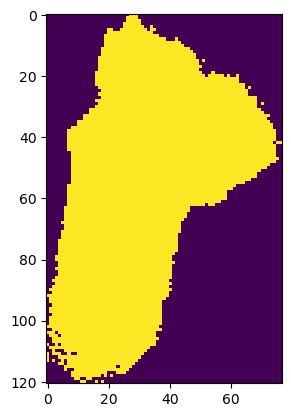

In [91]:
demo = mip6[12]
mask3 = demo['masks'][3].astype(np.uint8)
m3 = mahotas.features.zernike_moments(mask3, max(mask3.shape)/2, degree=8)
imshow(mask3)

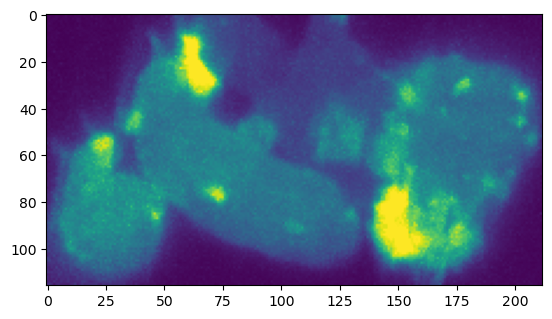

In [98]:
imshow(demo['patches'][4])

In [100]:
imshow(cv2.cvtColor(demo['patches'][4], cv2.COLOR_BGR2GRAY))

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [107]:
demo['patches'][4] * 255

array([[ 3.75      ,  4.09090909,  5.79545455, ...,  5.45454545,
         8.52272727,  5.45454545],
       [ 5.79545455,  7.15909091,  5.11363636, ...,  8.86363636,
        12.27272727,  7.15909091],
       [ 4.09090909,  6.13636364,  6.81818182, ...,  9.88636364,
         5.45454545,  4.77272727],
       ...,
       [32.72727273, 23.18181818, 30.34090909, ...,  5.11363636,
         7.5       ,  5.11363636],
       [27.27272727, 29.65909091, 24.54545455, ...,  6.47727273,
         6.81818182,  8.52272727],
       [33.75      , 40.90909091, 33.75      , ...,  9.20454545,
         4.77272727,  5.79545455]])

In [45]:
patch = (mip3[5]['patches'][4]).astype(np.uint16)

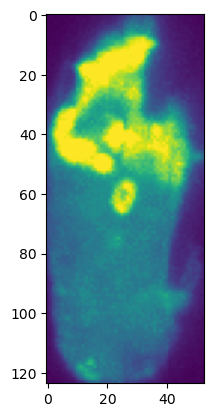

In [44]:
imshow(patch)

In [46]:
mahotas.features.haralick(patch).mean(axis=0)

array([ 0.8651887 ,  0.02929511,  0.72483478,  0.05319408,  0.98535245,
        0.11274418,  0.18348123,  0.43877573,  0.46807083,  0.22157687,
        0.19049379, -0.50413626,  0.51952618])

In [101]:
demo['patches'][4].shape

(116, 212)

In [ ]:


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
features = mahotas.features.haralick(gray).mean(axis=0)

# Dimensionality Reduction and Manifold Learning on Trajectories

In [8]:
import umap
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/root/anaconda3/envs/sammy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from utils import *

In [29]:
sns.set_style("whitegrid")

### Aggregating Useful Things

In [34]:
def get_centroids(cell_data):
    boxes, masks = np.array(cell_data['boxes']), cell_data['masks']
    N = len(masks)
    res = []
    centroids = [skm.centroid(binary.astype(np.uint8)) for binary in masks]
    for i in range(N):
        c = centroids[i]
        ymin, xmin = boxes[i][:2]
        res.append([xmin+c[0], ymin+c[1]])
    return(np.array(res) - res[0])


In [28]:
def compute_trajectory_similarity(t1, t2):
    assert len(t1) == len(t2), "trajectories should be same length"
    def normalized_deltas(t):
        deltas = np.abs(np.array([t[i+1,:2] - t[i,:2] for i in range(len(t)-1)] ))
        return(deltas / np.sum(deltas, axis=0))
    d1 = normalized_deltas(t1)
    d2 = normalized_deltas(t2)
    #print(d1,"\n")
    #print(d2,"\n")
    #print(np.abs(d1-d2), "\n")
    return(np.abs(d1-d2).mean())

In [60]:
def plot_trajectory(cell_data):
    loc = get_centroids(cell_data)
    xs, ys = loc[:,0], loc[:,1]
    sns.scatterplot(x=xs[1:], y=ys[1:], color='blue', marker='o')
    sns.lineplot(x=xs, y=ys, color='red', linestyle='--', sort=False)
    sns.scatterplot(x=[xs[0]], y=[ys[0]], color='green', label='Start')
    plt.legend()
    plt.show()
    return(loc)

In [29]:
def shape_features(binary, feature_length=20, num_samples=180):
    def radial_distance(binary, theta):
        height, width = binary.shape
        center = [width // 2, height // 2]
        def test_r(r):
            x_test, y_test = center[0] + r*np.cos(theta), center[1] + r*np.sin(theta)
            if(x_test >= width or y_test > height or x_test < 0 or y_test < 0):
                return(False)
            return(binary[int(y_test), int(x_test)])
        # calculate distance to the nearest pixel
        r = max(height, width)
        while(not test_r(r)): # start from edge come inside until hit cell
            r -= 1
        return(r)

    test_angles = np.linspace(0, 2*np.pi, num_samples)
    distances = np.array([radial_distance(binary, angle) for angle in test_angles])
    fft_coefficients = np.fft.rfft(distances)

    features = np.abs(fft_coefficients[:feature_length])
    features = features / np.sum(features)
    return(features, (distances, fft_coefficients))

In [30]:
def featurize(cell_data, index):
    image, binary = cell_data['patches'][index], cell_data['masks'][index].astype(np.uint8)
    zernike = mahotas.features.zernike_moments(binary, max(binary.shape)/2, degree=8)
    #zernike = zernike / zernike.sum()
    haralick = mahotas.features.haralick(image.astype(np.uint16)).mean(axis=0)
    #haralick = haralick / haralick.sum()
    shape, info = shape_features(binary, 20)
    #print(f"Zernike: {zernike.shape}, Haralick: {haralick.shape}, Radial Shape: {shape.shape}")
    return(np.concatenate([zernike, haralick, shape]))

In [31]:
pca = PCA(n_components=3, svd_solver='full')
def get_trajectory_embeddding(trace):
    N = len(trace['boxes'])
    trajectory_features = np.array([featurize(trace, index) for index in range(N)])
    embeddings = pca.fit_transform(trajectory_features)

    return(embeddings)

In [67]:
pca = PCA(n_components=3, svd_solver='full')
def trajectory_shape_loc_comparison(idx):
    cell_data = traces.all_traces[idx]
    trajectory_features = np.array([featurize(cell_data, index) for index in range(len(cell_data['boxes']))])
    loc = get_centroids(cell_data)
    embeddings = pca.fit_transform(trajectory_features)
    diff = compute_trajectory_similarity(loc, embeddings)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    sns.scatterplot(x=loc[1:,0], y=loc[1:,1], ax=axs[0], color='blue', marker='o')
    sns.lineplot(x=loc[:,0], y=loc[:,1], ax=axs[0], color='red', linestyle='--', sort=False)
    axs[0].plot(loc[0,0], loc[0,1], 'g*', markersize=10, label='Start')
    axs[0].set_title('Trajectory of Cell Centroid')
    axs[0].legend()
    
    # Plot on the second subplot (axs[1]) using Seaborn
    sns.scatterplot(x=embeddings[1:,0], y=embeddings[1:,1], ax=axs[1], color='red')
    sns.lineplot(x=embeddings[:,0], y=embeddings[:,1], ax=axs[1], color='blue', linestyle='--', sort=False)
    axs[1].plot(embeddings[0,0], embeddings[0,1], 'g*', markersize=10)
    axs[1].set_title("Trajectory of Principal Components of Extracted Features")

    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    return(diff)

## Sparse Video Loader

In [3]:
def extract_traces_sparse(frames, masks, hist=2):
    bboxes, num_cells, areas = bounding_boxes(masks[0])
    vid_data = []
    for i in range(num_cells):
        #print("Extracting cell ", i)
        data = track_cells(i, frames, masks, padding=0, history_length=hist, verbose=False)
        vid_data.append(data)
    return(vid_data)

In [4]:
mip_video_files = [
    ('mip', 3),
    ('mip', 6),
    ('mip', 9),
]

In [152]:
class SparseMIPVideo:
    def __init__(self, files, sequence_length, hist_length=2):
        self.data = {}
        self.all_traces = []
        self.N = sequence_length
        for category, num in files:
            print(f"Loading in MIP {num}")
            assert category == 'mip', "Can't load non Mip file"
            video = get_file(category, num)
            frames, shp = video.read_image(C=0)
            frames = scale_img(frames.squeeze())
            print(f"frames {num}: {frames.shape}")
            masks = binarize_video(frames)

            print(f"Finished loading frames and masks for MIP {num}")

            N = len(frames)
            s = 0
        
            for i in range(N // sequence_length):
                print(f"Extracting traces from {s}:{s+sequence_length}")
                data = extract_traces_sparse(frames[s:s+sequence_length], masks[s:s+sequence_length], hist=hist_length)
                s += sequence_length
                self.all_traces = self.all_traces + data
            
            if(N % sequence_length > 0):
                data = extract_traces_sparse(frames[-1*sequence_length:], masks[-1*sequence_length:], hist=hist_length)
                self.all_traces = self.all_traces + data

    def featurize_traces(self):
        self.featurized_frames = []
        for i, trace in enumerate(self.all_traces):
            if(i % 100 == 0):
                print(i)
            trajectory_features = np.array([featurize(trace, index) for index in range(5)])
            self.featurized_frames.append(trajectory_features)

In [17]:
class VideoDataProcessed:
    def __init__(self, files, sequence_length=5, channel=0):
        self.data = {}
        self.all_traces = []
        self.seq_length = sequence_length
        self.channel = channel
        self.videos = {}
        for category, num in files:
            print(f"Loading in processed {num}")
            assert category == 'processed', "Can't load non processed file"
            video = get_file(category, num)
            self.videos[num] = video

    def extract_planes(self, num, zplanes, hist_length):
        for z in zplanes:
            self.extract_slice_traces(num, z, hist_length)
    
    def extract_slice_traces(self, num, zPlane, hist_length=2):
        assert num in self.videos.keys(), f"Video {num} not found"
        
        video = self.videos[num]
        frames, shp = video.read_image(C=self.channel, S=0, Z=zPlane)
        frames = scale_img(frames.squeeze())
        print(f"vid {num} zplane {zPlane} with frames: {frames.shape}")
        masks = binarize_video(frames)
        N = len(frames)
        s = 0
        for i in range(N // self.seq_length):
            print(f"Extracting traces from {s}:{s+self.seq_length}")
            data = extract_traces_sparse(frames[s:s+self.seq_length], masks[s:s+self.seq_length], hist=hist_length)
            s += self.seq_length
            self.all_traces = self.all_traces + data
        
        if(N % self.seq_length > 0):
            data = extract_traces_sparse(frames[-1*sequence_length:], masks[-1*sequence_length:], hist=hist_length)
            self.all_traces = self.all_traces + data

In [15]:
vids = VideoDataProcessed([('processed', 3)])

Loading in processed 3
Loading dicty_factin_pip3-03_processed.czi with dims [{'X': (0, 475), 'Y': (0, 2048), 'Z': (0, 114), 'C': (0, 2), 'T': (0, 90), 'S': (0, 1)}]


In [16]:
vids.extract_slice_traces(3, 50)

50 frames 3: (90, 2048, 475)
Extracting traces from 0:5
Extracting traces from 5:10
Extracting traces from 10:15
Extracting traces from 15:20
Extracting traces from 20:25
Extracting traces from 25:30
Extracting traces from 30:35
Extracting traces from 35:40
Extracting traces from 40:45
Extracting traces from 45:50
Extracting traces from 50:55
Extracting traces from 55:60
Extracting traces from 60:65
Extracting traces from 65:70
Extracting traces from 70:75
Extracting traces from 75:80
Extracting traces from 80:85
Extracting traces from 85:90


56


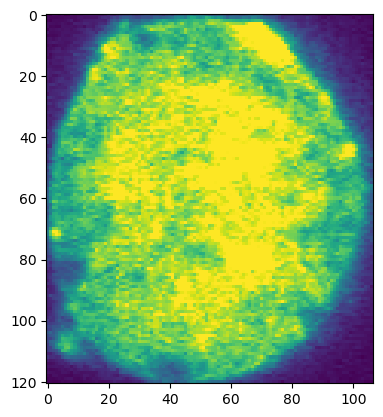

In [31]:
print(len(vids.all_traces))
imshow(vids.all_traces[1]['patches'][4])

In [21]:
traces = SparseMIPVideo(mip_video_files, sequence_length=5)

Loading in MIP 3
Loading dicty_factin_pip3-03_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 90)}]
frames 3: (90, 2048, 474)
Finished loading frames and masks for MIP 3
Extracting traces from 0:5
Extracting traces from 5:10
Extracting traces from 10:15
Extracting traces from 15:20
Extracting traces from 20:25
Extracting traces from 25:30
Extracting traces from 30:35
Extracting traces from 35:40
Extracting traces from 40:45
Extracting traces from 45:50
Extracting traces from 50:55
Extracting traces from 55:60
Extracting traces from 60:65
Extracting traces from 65:70
Extracting traces from 70:75
Extracting traces from 75:80
Extracting traces from 80:85
Extracting traces from 85:90
Loading in MIP 6
Loading dicty_factin_pip3-06_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 241)}]
frames 6: (241, 2048, 474)
Finished loading frames and masks for MIP 6
Extracting traces from 0:5
Extracting traces from 5:10
Extracting traces from 10:15
Extra

In [155]:
SparseMIPVideo.featurize_traces(traces)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [17]:
test_trace.keys()

dict_keys(['patches', 'boxes', 'masks'])

In [26]:
traces.cell_embeddings[0]

array([[-0.49126198, -0.08934799,  0.14865299],
       [ 0.18168557,  0.07749187,  0.10122036],
       [-0.00833377,  0.29495752, -0.06680331],
       [-0.5939156 , -0.13456815, -0.14677722],
       [ 0.91182577, -0.14853325, -0.03629281]])

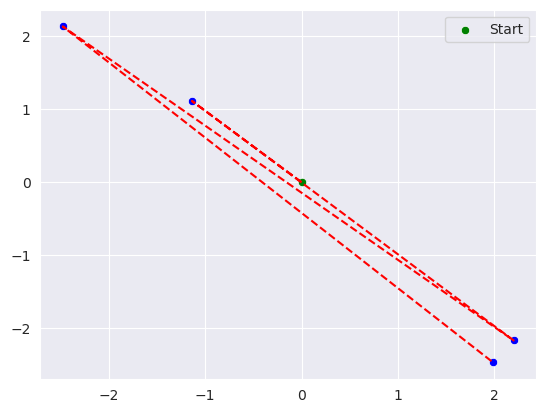

In [57]:
loc = plot_trajectory(traces.all_traces[10])

In [31]:
%%time
get_trajectory_embeddding(test_trace)

CPU times: user 226 ms, sys: 100 µs, total: 226 ms
Wall time: 225 ms


array([[-0.49126198, -0.08934799,  0.14865299],
       [ 0.18168557,  0.07749187,  0.10122036],
       [-0.00833377,  0.29495752, -0.06680331],
       [-0.5939156 , -0.13456815, -0.14677722],
       [ 0.91182577, -0.14853325, -0.03629281]])

In [32]:
"""cell_embeddings = []

for i, trace in enumerate(traces.all_traces):
    if(i % 100 == 0):
        print(f"Embedding trace {i}")
    cell_embeddings.append(get_trajectory_embeddding(trace))
traces.cell_embeddings = np.array(cell_embeddings)
#np.save('mip_trace_cell_embeddings.npy', traces.cell_embeddings)"""

Embedding trace 0
Embedding trace 100
Embedding trace 200
Embedding trace 300
Embedding trace 400
Embedding trace 500
Embedding trace 600
Embedding trace 700
Embedding trace 800
Embedding trace 900
Embedding trace 1000
Embedding trace 1100
Embedding trace 1200
Embedding trace 1300
Embedding trace 1400
Embedding trace 1500


In [56]:
loc = get_centroids(traces.all_traces[2])
loc

array([[ 0.        ,  0.        ],
       [-1.3262919 ,  3.70951647],
       [-3.41110589,  8.0577994 ],
       [ 3.13694076,  2.15993965],
       [-6.62978068, 11.89803167]])

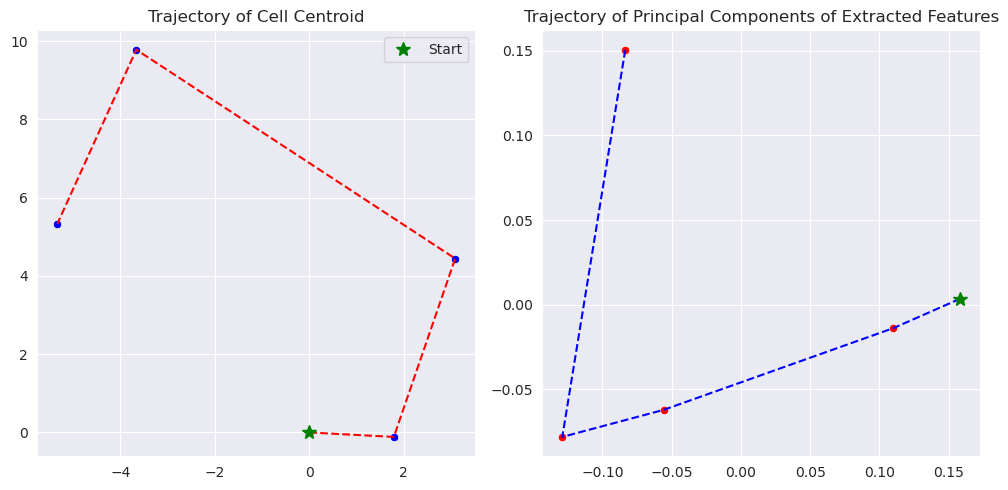

0.21577207645346044

In [69]:
trajectory_shape_loc_comparison(325)

## UMAP Reduction

In [71]:
traces.cell_embeddings = np.load('mip_trace_cell_embeddings.npy')

In [18]:
E = np.load('mip_trace_cell_embeddings.npy')
E.shape

(1575, 5, 3)

In [ ]:
plt

In [72]:
N = len(traces.cell_embeddings)
N

1575

In [73]:
trajectory_data_matrix = traces.cell_embeddings.reshape(N, -1)

In [74]:
trajectory_data_matrix.shape

(1575, 15)

In [75]:
reducer = umap.UMAP()

In [76]:
reducer

UMAP()

In [146]:
%%time
reducer = umap.UMAP()
reducer.fit(trajectory_data_matrix)

CPU times: user 24 s, sys: 373 ms, total: 24.3 s
Wall time: 4.72 s


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [147]:
reducer.embedding_.shape

(1575, 2)

In [82]:
test_trace = traces.all_traces[15]

In [119]:
def total_distance(trace):
    t = get_centroids(trace)
    deltas = np.abs(np.array([t[i+1,:2] - t[i,:2] for i in range(len(t)-1)]))
    dist = np.sqrt(np.sum(deltas ** 2, axis=1)).sum()
    return(dist)
total_distance(traces.all_traces[25])

62.178372732989544

In [128]:
distance_traveled = []

for i, trace in enumerate(traces.all_traces):
    distance_traveled.append(total_distance(trace))

In [129]:
distance_traveled = np.array(distance_traveled)

<Axes: >

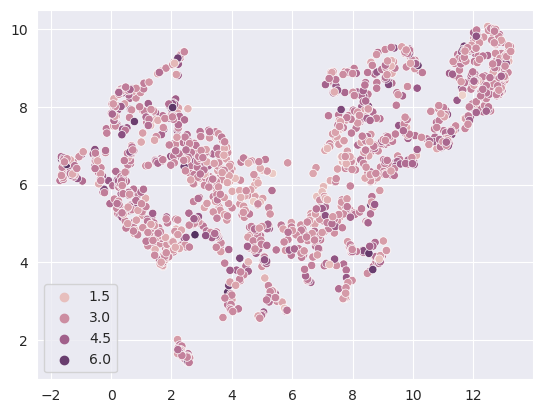

In [130]:
sns.scatterplot(x=trajectory_embeddings[:,0], y=trajectory_embeddings[:,1], hue=np.log(distance_traveled))

(array([1.539e+03, 2.200e+01, 9.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.98696004e-05, 2.66131485e-03, 5.28276010e-03, 7.90420534e-03,
        1.05256506e-02, 1.31470958e-02, 1.57685411e-02, 1.83899863e-02,
        2.10114316e-02, 2.36328768e-02, 2.62543221e-02]),
 <BarContainer object of 10 artists>)

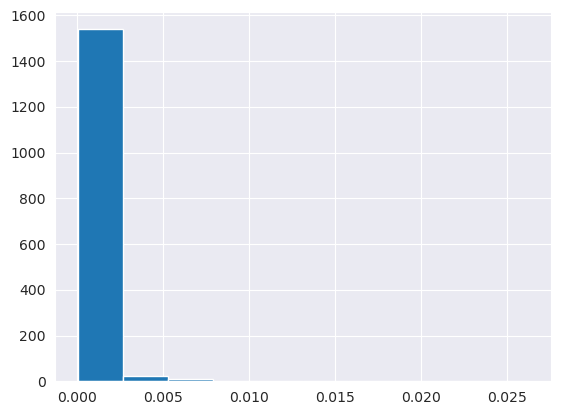

In [125]:
plt.hist(distance_traveled)

In [131]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [132]:
penguins = penguins.dropna()
penguins.species.value_counts()

species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

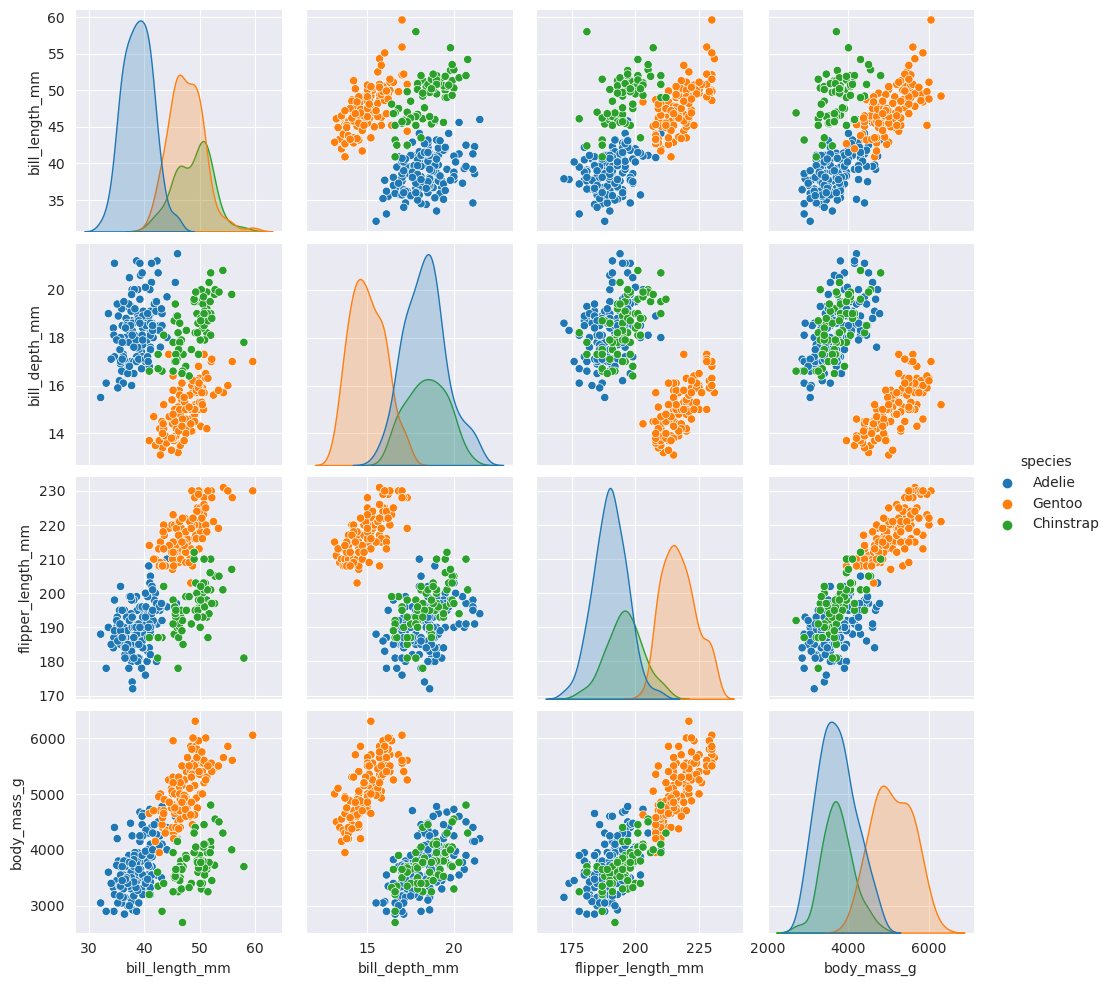

In [133]:
sns.pairplot(penguins.drop("year", axis=1), hue='species');

In [134]:
reducer = umap.UMAP()

In [136]:

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [137]:
penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

In [138]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [139]:
embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

(333, 2)

In [144]:
penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})

0      0
1      0
2      0
4      0
5      0
      ..
339    1
340    1
341    1
342    1
343    1
Name: species, Length: 333, dtype: int64

In [141]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

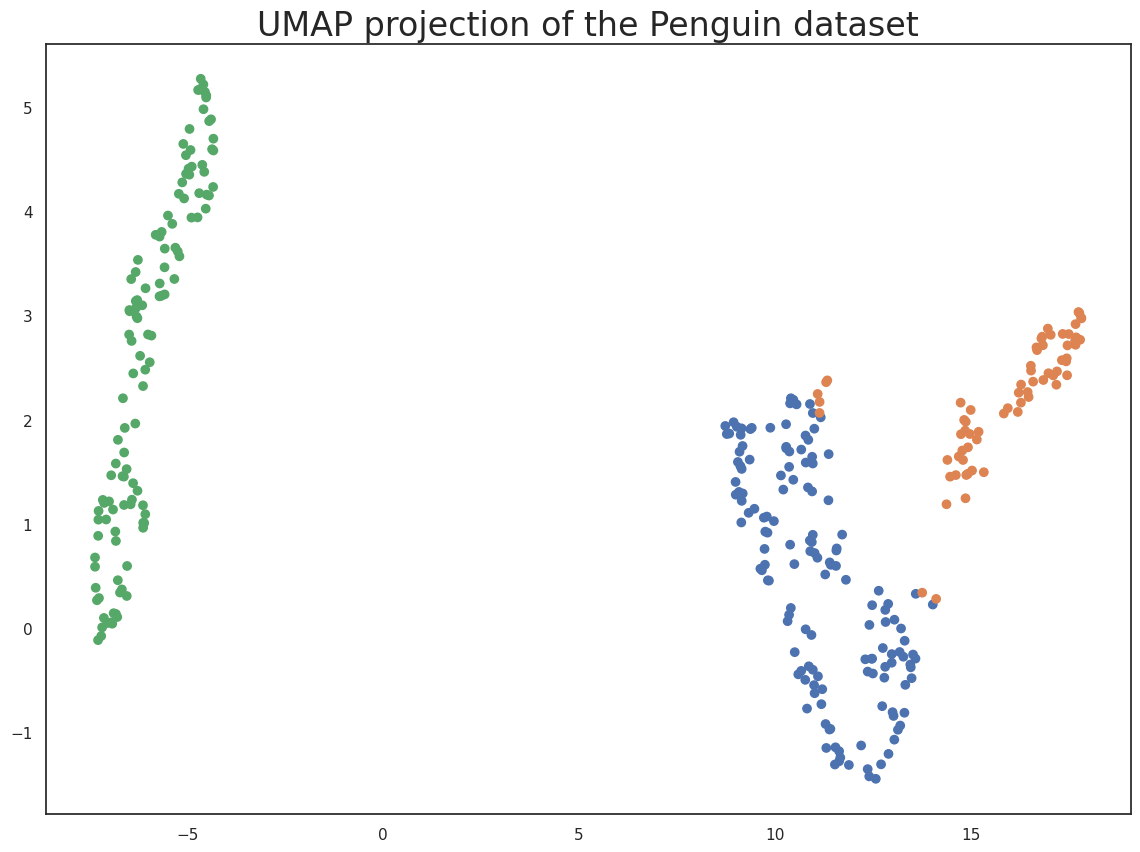

In [145]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24);